In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import eig
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from umap import UMAP
from scipy.stats import norm
from scipy.special import kl_div
from scipy.stats import entropy
from scipy.spatial.distance import cdist 
import math
import time
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans, BisectingKMeans
from sklearn.cluster import DBSCAN
import datetime as dt
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import dask as dd
%matplotlib inline

import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime as dt
import sys, os
from contextlib import contextmanager

In [2]:
tic = time.time()
business = pd.read_json('/Users/zhanglinyue/Downloads/MSiA421_Data Mining/archive/yelp_academic_dataset_business.json', lines = True)
toc = time.time()
print(f"Time taken to read the full business table is {round(toc-tic, 2)} seconds")

Time taken to read the full business table is 2.5 seconds


In [3]:
business.rename(columns = {'stars': 'business_stars', 'name': 'business_name', 'review_count': 'review_count_business'}, inplace = True)

In [4]:
business.columns

Index(['business_id', 'business_name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_stars',
       'review_count_business', 'is_open', 'attributes', 'categories',
       'hours'],
      dtype='object')

In [5]:
# checkin = pd.read_json('/Users/kalra/Documents/Northwestern/quarter2/421 Data Mining/yelp_dataset/yelp_academic_dataset_checkin.json', lines = True, chunksize = 1000000) # Business id and date. Not needed as of now

In [6]:
nrows = 500000
tic = time.time()
review = pd.read_json('/Users/zhanglinyue/Downloads/MSiA421_Data Mining/archive/yelp_academic_dataset_review.json', lines = True, nrows = nrows)
toc = time.time()
print(f"Time taken to read the review table with nrows = {nrows} is {round(toc-tic, 2)} seconds")

Time taken to read the review table with nrows = 500000 is 4.93 seconds


In [7]:
print(review.shape)

(500000, 9)


In [8]:
review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [9]:
business_reviews = pd.merge(business, review, how = 'right', on = 'business_id')

In [10]:
pd.set_option('display.max_columns', None)
business_reviews.head(2)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,business_stars,review_count_business,is_open,attributes,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date
0,XQfwVwDr-v0ZS3_CbbE5Xw,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...",KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,7ATYjTIgM3jUlt4UM3IypQ,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...",BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [11]:
# tip = pd.read_json('/Users/kalra/Documents/Northwestern/quarter2/421 Data Mining/yelp_dataset/yelp_academic_dataset_tip.json', lines = True) # Compliment count

In [12]:
# tip.shape (908915, 5)

In [13]:
# tip.sort_values(by = 'compliment_count', ascending = False)

In [14]:
tic = time.time()
nrows = 200000
user = pd.read_json('/Users/zhanglinyue/Downloads/MSiA421_Data Mining/archive/yelp_academic_dataset_user.json', lines = True, nrows = nrows)
toc = time.time()
print(f"Time taken to read the user table with nrows = {nrows} is {round(toc-tic, 2)} seconds")

Time taken to read the user table with nrows = 200000 is 5.21 seconds


In [15]:
user.shape

(200000, 22)

In [16]:
pd.set_option('display.max_columns', None)
user.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,3.91,250,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,3.74,1145,264,184,157,251,1847,7054,3131,3131,1521,1946


In [17]:
user.rename(columns = {'review_count': 'review_count_user', 'cool': 'cool_user', 'funny': 'funny_user', 'useful': 'useful_user'}, inplace = True)

In [25]:
user.columns

Index(['user_id', 'name', 'review_count_user', 'yelping_since', 'useful_user',
       'funny_user', 'cool_user', 'elite', 'friends', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos'],
      dtype='object')

In [26]:
tic = time.time()
business_reviews_user = pd.merge(business_reviews, user, how = 'left', on = 'user_id')
toc = time.time()
print(f"Time taken to join = {round(toc-tic, 2)} seconds")

Time taken to join = 0.49 seconds


In [27]:
business_reviews_user.shape

(500000, 43)

In [28]:
pd.set_option('display.max_columns', None)
business_reviews_user.head(2)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,business_stars,review_count_business,is_open,attributes,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date,name,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,XQfwVwDr-v0ZS3_CbbE5Xw,Turning Point of North Wales,1460 Bethlehem Pike,North Wales,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'...",KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Melanie,33.0,2016-01-13 17:20:44,32.0,3.0,8.0,,"DS9QBM_NWJz1E279Zrao-A, XdXgIs4i5JFvtJf0rJlWsA...",0.0,4.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,7ATYjTIgM3jUlt4UM3IypQ,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...",BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Erin,10.0,2011-03-07 19:45:15,6.0,1.0,2.0,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0.0,4.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


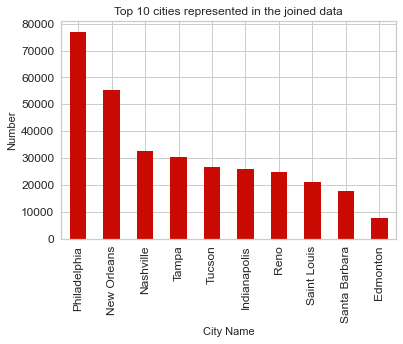

In [29]:
business_reviews_user.city.value_counts(sort = True, ascending = False).head(10).plot(kind = 'bar', title = 'Top 10 cities represented in the joined data', xlabel = 'City Name', ylabel = 'Number', color = 'r', fontsize = 12); # Top 10 cities

Philadelphia is the most represented city therefore we will subset it for doing the analysis

In [30]:
city_to_subset = 'Philadelphia'

In [31]:
tic = time.time()
city_df = business_reviews_user[business_reviews_user['city'] == 'Philadelphia']
toc = time.time()
print(f"Time taken to subset the city {city_to_subset} is {round(toc - tic, 2)} seconds")

Time taken to subset the city Philadelphia is 0.27 seconds


In [32]:
city_df.shape

(77112, 43)

In [33]:
city_df.head(2)

,business_id,business_name,address,city,state,postal_code,latitude,longitude,business_stars,review_count_business,is_open,attributes,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date,name,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
1,7ATYjTIgM3jUlt4UM3IypQ,Body Cycle Spinning Studio,"1923 Chestnut St, 2nd Fl",Philadelphia,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3...",BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Erin,10.0,2011-03-07 19:45:15,6.0,1.0,2.0,,"7uYgWwryg8KH33i1SLJUTQ, 0mGJMNL8o2AY4BT1d4TTDQ...",0.0,4.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,kxX2SOes4o-D3ZQBkiMRfA,Zaika,2481 Grant Ave,Philadelphia,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Kyle,9.0,2014-01-17 19:20:57,1.0,0.0,1.0,,None,0.0,4.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
city_df.columns

Index(['business_id', 'business_name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_stars',
       'review_count_business', 'is_open', 'attributes', 'categories', 'hours',
       'review_id', 'user_id', 'stars', 'useful', 'funny', 'cool', 'text',
       'date', 'name', 'review_count_user', 'yelping_since', 'useful_user',
       'funny_user', 'cool_user', 'elite', 'friends', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos'],
      dtype='object')

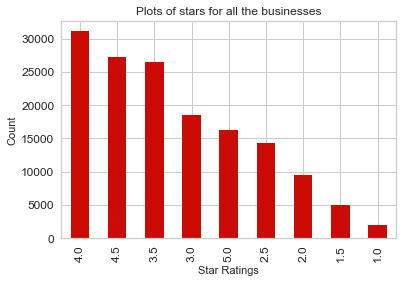

In [35]:
business.business_stars.value_counts(sort = True, ascending = False).plot(kind = 'bar', title = 'Plots of stars for all the businesses', xlabel = 'Star Ratings', ylabel = 'Count', color = 'r', fontsize = 12);

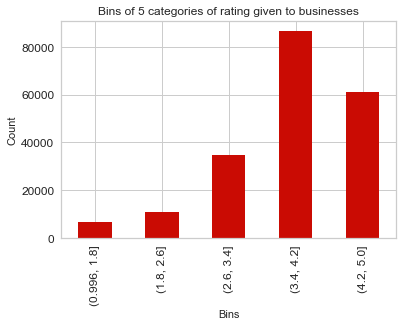

In [36]:
pd.cut(user.average_stars.values, bins = 5, ordered = True).value_counts().plot(kind = 'bar', title = 'Bins of 5 categories of rating given to businesses', xlabel = 'Bins', ylabel = 'Count', color = 'r', fontsize = 12); # Binning in 5 bins, we see that the 3.4 to 4.2 is the most common star rating

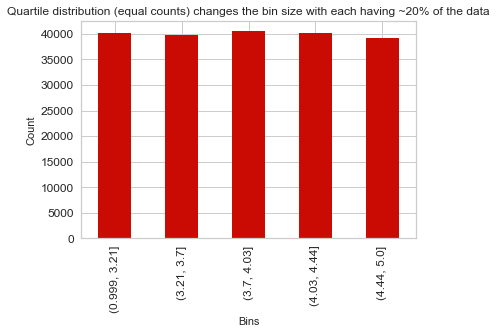

In [37]:
pd.qcut(user.average_stars.values, 5).value_counts().plot(kind = 'bar', title = 'Quartile distribution (equal counts) changes the bin size with each having ~20% of the data', ylabel = "Count", xlabel = "Bins", color = 'r', fontsize = 12); # Using qcut to give quartile distribution changes the bin with each having ~20% of the data

In [38]:
cats = ' '.join(business.categories.dropna().values).split(' ')

In [39]:
cats = pd.Series(cats, name = 'categories').str.replace(',', '').str.replace('&', '')

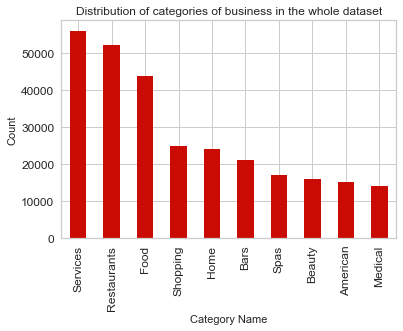

In [40]:
cats.value_counts().iloc[1:].head(10).plot(kind = 'bar', color = 'r', fontsize = 12, title = 'Distribution of categories of business in the whole dataset', xlabel = 'Category Name', ylabel = 'Count');

/var/folders/lp/82840zd14mgc4dpzfxwwy1cm0000gn/T/ipykernel_83425/1783493605.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pd.Series(' '.join(city_df.categories.dropna().values).split(' '), name = 'categories').str.replace(',', '').str.replace('&', '').str.replace('(', '').str.replace(')', '').value_counts().iloc[2:].head(10).plot(kind = 'bar', color = 'r', fontsize = 12, title = f'Distribution of categories of business in {city_to_subset}', xlabel = 'Category Name', ylabel = 'Count');


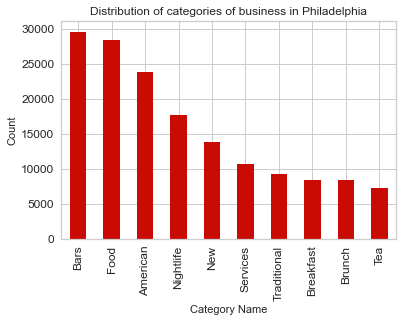

In [41]:
pd.Series(' '.join(city_df.categories.dropna().values).split(' '), name = 'categories').str.replace(',', '').str.replace('&', '').str.replace('(', '').str.replace(')', '').value_counts().iloc[2:].head(10).plot(kind = 'bar', color = 'r', fontsize = 12, title = f'Distribution of categories of business in {city_to_subset}', xlabel = 'Category Name', ylabel = 'Count');

## Data preprocessing

In [42]:
# getting just restaurants from Philadelphia business
df = city_df[city_df['categories'].str.contains('Restaurant.*')==True].reset_index()
#set no limit on the number of columns that can be displayed
pd.set_option('display.max_columns', None)
df.head()

,index,business_id,business_name,address,city,state,postal_code,latitude,longitude,business_stars,review_count_business,is_open,attributes,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date,name,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,3,kxX2SOes4o-D3ZQBkiMRfA,Zaika,2481 Grant Ave,Philadelphia,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Kyle,9.0,2014-01-17 19:20:57,1.0,0.0,1.0,,None,0.0,4.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,04UD14gamNjLY0IDYVhHJg,Dmitri's,795 S 3rd St,Philadelphia,PA,19147,39.938013,-75.148131,4.0,273,0,"{'BusinessParking': '{'garage': False, 'street...","Mediterranean, Restaurants, Seafood, Greek","{'Wednesday': '17:30-21:0', 'Thursday': '17:30...",JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,Q,4.0,2014-06-15 18:44:27,5.0,7.0,1.0,,OMh0c33LlCxUt0Ju2IUDMw,0.0,2.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,13,RZtGWDLCAtuipwaZ-UfjmQ,LaScala's,615 Chestnut St,Philadelphia,PA,19106,39.949529,-75.152139,3.5,367,0,"{'RestaurantsReservations': 'True', 'BYOBCorka...","Pizza, Restaurants, Italian, Salad","{'Monday': '0:0-0:0', 'Tuesday': '11:30-21:0',...",8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,Meg,176.0,2009-09-28 01:53:09,120.0,32.0,29.0,,"_BcWyKQL16ndpBdggh2kNA, 6Mv-qMJyxSokCu8YFM1o0A...",1.0,3.46,0.0,0.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,0.0,0.0
3,16,YtSqYv1Q_pOltsVPSx54SA,Rittenhouse Grill,1701 Locust St,Philadelphia,PA,19103,39.948949,-75.169532,3.5,290,1,"{'RestaurantsAttire': 'u'dressy'', 'Restaurant...","Wine Bars, Restaurants, Nightlife, Steakhouses...","{'Wednesday': '16:30-22:0', 'Thursday': '16:30...",oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,5,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,Jack,2.0,2013-05-26 02:27:11,3.0,2.0,1.0,,_ISwgxjUZm8hFIU-53UsDQ,0.0,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,19,eFvzHawVJofxSnD7TgbZtg,Good Karma Cafe,928 Pine St,Philadelphia,PA,19107,39.944609,-75.157833,4.0,249,1,"{'Alcohol': 'u'none'', 'RestaurantsReservation...","Food, Cafes, Coffee & Tea, Restaurants","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,5,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,Dana,182.0,2010-02-22 16:15:28,217.0,33.0,40.0,2018,"YTDadrj2g1BrGsxcyQ0Kew, CKf0U33HQlUIG62yufzH7A...",6.0,3.41,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,4.0,0.0,0.0


In [43]:
# get the open restaurant
df = df[df['is_open'] == 1]

In [44]:
df.shape

(37503, 44)

In [45]:
# drop useless columns based on initial thoughs
df_new = df.drop(columns = ['business_id','city','state','latitude','longitude','is_open','review_id','user_id','name','friends','elite'])
df_new.head()

,index,business_name,address,postal_code,business_stars,review_count_business,attributes,categories,hours,stars,useful,funny,cool,text,date,review_count_user,yelping_since,useful_user,funny_user,cool_user,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,3,Zaika,2481 Grant Ave,19114,4.0,181,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,9.0,2014-01-17 19:20:57,1.0,0.0,1.0,0.0,4.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,Rittenhouse Grill,1701 Locust St,19103,3.5,290,"{'RestaurantsAttire': 'u'dressy'', 'Restaurant...","Wine Bars, Restaurants, Nightlife, Steakhouses...","{'Wednesday': '16:30-22:0', 'Thursday': '16:30...",5,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2.0,2013-05-26 02:27:11,3.0,2.0,1.0,0.0,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,19,Good Karma Cafe,928 Pine St,19107,4.0,249,"{'Alcohol': 'u'none'', 'RestaurantsReservation...","Food, Cafes, Coffee & Tea, Restaurants","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",5,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,182.0,2010-02-22 16:15:28,217.0,33.0,40.0,6.0,3.41,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,4.0,0.0,0.0
5,38,The Coventry Deli,2000 Market St,19103,4.0,65,"{'Corkage': 'False', 'BusinessAcceptsCreditCar...","Restaurants, Delis, Salad, Sandwiches","{'Monday': '6:0-15:0', 'Tuesday': '6:0-15:0', ...",5,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,84.0,2017-07-07 00:33:21,75.0,7.0,38.0,5.0,3.93,1.0,0.0,1.0,0.0,0.0,7.0,3.0,3.0,3.0,1.0,5.0
6,42,Square 1682,121 S 17th St,19103,3.5,385,"{'RestaurantsPriceRange2': '2', 'Alcohol': 'u'...","American (New), Breakfast & Brunch, Bars, Nigh...","{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ...",4,0,0,0,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,68.0,2010-10-27 20:57:03,72.0,14.0,10.0,2.0,3.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [46]:
# make columns for year and yearmonth (YRMO)
df_new['yelping_since'] = pd.to_datetime(df_new['yelping_since'])
df_new['yelp_since_YRMO'] = df_new['yelping_since'].map(lambda x: 100*x.year + x.month)
df_new['yelp_since_year'] = df_new['yelping_since'].dt.year
df_new.head()

,index,business_name,address,postal_code,business_stars,review_count_business,attributes,categories,hours,stars,useful,funny,cool,text,date,review_count_user,yelping_since,useful_user,funny_user,cool_user,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,yelp_since_YRMO,yelp_since_year
0,3,Zaika,2481 Grant Ave,19114,4.0,181,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,9.0,2014-01-17 19:20:57,1.0,0.0,1.0,0.0,4.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201401.0,2014.0
3,16,Rittenhouse Grill,1701 Locust St,19103,3.5,290,"{'RestaurantsAttire': 'u'dressy'', 'Restaurant...","Wine Bars, Restaurants, Nightlife, Steakhouses...","{'Wednesday': '16:30-22:0', 'Thursday': '16:30...",5,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2.0,2013-05-26 02:27:11,3.0,2.0,1.0,0.0,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,201305.0,2013.0
4,19,Good Karma Cafe,928 Pine St,19107,4.0,249,"{'Alcohol': 'u'none'', 'RestaurantsReservation...","Food, Cafes, Coffee & Tea, Restaurants","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",5,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,182.0,2010-02-22 16:15:28,217.0,33.0,40.0,6.0,3.41,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,4.0,0.0,0.0,201002.0,2010.0
5,38,The Coventry Deli,2000 Market St,19103,4.0,65,"{'Corkage': 'False', 'BusinessAcceptsCreditCar...","Restaurants, Delis, Salad, Sandwiches","{'Monday': '6:0-15:0', 'Tuesday': '6:0-15:0', ...",5,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,84.0,2017-07-07 00:33:21,75.0,7.0,38.0,5.0,3.93,1.0,0.0,1.0,0.0,0.0,7.0,3.0,3.0,3.0,1.0,5.0,201707.0,2017.0
6,42,Square 1682,121 S 17th St,19103,3.5,385,"{'RestaurantsPriceRange2': '2', 'Alcohol': 'u'...","American (New), Breakfast & Brunch, Bars, Nigh...","{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ...",4,0,0,0,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,68.0,2010-10-27 20:57:03,72.0,14.0,10.0,2.0,3.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,201010.0,2010.0


In [47]:
df_new.shape

(37503, 35)

In [48]:
df_new.columns

Index(['index', 'business_name', 'address', 'postal_code', 'business_stars',
       'review_count_business', 'attributes', 'categories', 'hours', 'stars',
       'useful', 'funny', 'cool', 'text', 'date', 'review_count_user',
       'yelping_since', 'useful_user', 'funny_user', 'cool_user', 'fans',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos',
       'yelp_since_YRMO', 'yelp_since_year'],
      dtype='object')

In [49]:
# Column to store whether compliment has been tagged
tagged_compliment = [0 for _ in range(df_new.shape[0])]
for i in range(df_new.shape[0]):
    if sum(df_new.iloc[i, 22:33].values) > 0:
        tagged_compliment[i] = 1
        
tagged_compliment = pd.DataFrame(tagged_compliment)
df_new['tagged_compliment'] = tagged_compliment

In [50]:
df_new = df_new.drop(["yelping_since"], axis=1)

In [51]:
df_new.isnull().sum()

index                        0
business_name                0
address                      0
postal_code                  0
business_stars               0
review_count_business        0
attributes                   9
categories                   0
hours                     1276
stars                        0
useful                       0
funny                        0
cool                         0
text                         0
date                         0
review_count_user         7433
useful_user               7433
funny_user                7433
cool_user                 7433
fans                      7433
average_stars             7433
compliment_hot            7433
compliment_more           7433
compliment_profile        7433
compliment_cute           7433
compliment_list           7433
compliment_note           7433
compliment_plain          7433
compliment_cool           7433
compliment_funny          7433
compliment_writer         7433
compliment_photos         7433
yelp_sin

In [129]:
df_new.shape

(37503, 35)

In [130]:
# the dataset is still large enough compared with the NAs, so drop missing values
df_new = df_new.dropna()

In [131]:
df_new.isnull().sum()

index                    0
business_name            0
address                  0
postal_code              0
business_stars           0
review_count_business    0
attributes               0
categories               0
hours                    0
stars                    0
useful                   0
funny                    0
cool                     0
text                     0
date                     0
review_count_user        0
useful_user              0
funny_user               0
cool_user                0
fans                     0
average_stars            0
compliment_hot           0
compliment_more          0
compliment_profile       0
compliment_cute          0
compliment_list          0
compliment_note          0
compliment_plain         0
compliment_cool          0
compliment_funny         0
compliment_writer        0
compliment_photos        0
yelp_since_YRMO          0
yelp_since_year          0
tagged_compliment        0
dtype: int64

In [132]:
df_new.shape

(23230, 35)

## PCA

In [133]:
# scale the features
import random
random.seed(1234)
features = ['useful_user', 'funny_user', 'cool_user', 'fans',
       'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos',
       'tagged_compliment']
x = df_new.loc[:, features]
x = StandardScaler().fit_transform(x)

In [134]:
df_train = pd.DataFrame(x, columns=features)
df_train.head()

,useful_user,funny_user,cool_user,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,tagged_compliment
0,-0.137947,-0.080885,-0.094149,-0.115713,1.519717,-0.098812,-0.049046,-0.064240,-0.060112,-0.046595,-0.142096,-0.107554,-0.106200,-0.106200,-0.114188,-0.069781,0.816936
1,-0.137052,-0.079609,-0.094149,-0.115713,1.858016,-0.098812,-0.108985,-0.064240,-0.060112,-0.046595,-0.142096,-0.107554,-0.106200,-0.106200,-0.098258,-0.069781,0.816936
2,-0.041319,-0.059830,-0.073691,-0.053801,-0.586963,-0.098812,-0.108985,-0.064240,-0.060112,-0.046595,-0.095629,-0.083074,-0.080892,-0.080892,-0.114188,-0.069781,0.816936
3,-0.104843,-0.076419,-0.074740,-0.064120,0.212653,-0.089928,-0.108985,-0.009405,-0.060112,-0.046595,-0.033674,-0.089194,-0.087219,-0.087219,-0.098258,0.001717,0.816936
4,-0.106185,-0.071953,-0.089428,-0.095076,-0.832998,-0.089928,-0.108985,-0.064240,-0.060112,-0.046595,-0.142096,-0.107554,-0.106200,-0.106200,-0.082327,-0.069781,0.816936


In [135]:
df_train.describe()

,useful_user,funny_user,cool_user,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,tagged_compliment
count,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04,2.323000e+04
mean,3.188755e-17,-2.051887e-17,1.027369e-16,9.525939e-17,4.445292e-16,9.428353e-16,1.635456e-15,-2.214163e-15,-2.337071e-15,2.304310e-15,3.562894e-16,-1.161111e-15,-2.200503e-15,-2.200503e-15,5.300556e-16,2.937156e-16,2.054097e-14
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-1.383944e-01,-8.088481e-02,-9.467329e-02,-1.157128e-01,-4.292874e+00,-9.881192e-02,-1.089852e-01,-6.424049e-02,-6.011241e-02,-4.659450e-02,-1.420961e-01,-1.075540e-01,-1.062002e-01,-1.062002e-01,-1.141879e-01,-6.978070e-02,-1.224086e+00
25%,-1.348156e-01,-8.024680e-02,-9.362418e-02,-1.157128e-01,-4.485675e-01,-9.881192e-02,-1.089852e-01,-6.424049e-02,-6.011241e-02,-4.659450e-02,-1.420961e-01,-1.075540e-01,-1.062002e-01,-1.062002e-01,-1.141879e-01,-6.978070e-02,-1.224086e+00
50%,-1.231845e-01,-7.641873e-02,-8.995231e-02,-1.053942e-01,8.963540e-02,-9.881192e-02,-1.089852e-01,-6.424049e-02,-6.011241e-02,-4.659450e-02,-1.266072e-01,-1.014340e-01,-1.062002e-01,-1.062002e-01,-1.141879e-01,-6.978070e-02,8.169360e-01
75%,-6.637093e-02,-5.345035e-02,-6.477378e-02,-5.380091e-02,5.817066e-01,-8.104463e-02,-4.904568e-02,-6.424049e-02,-6.011241e-02,-4.659450e-02,-8.014040e-02,-8.307431e-02,-8.089210e-02,-8.089210e-02,-8.232714e-02,-5.548120e-02,8.169360e-01
max,9.214830e+01,1.184762e+02,1.026201e+02,1.288365e+02,1.858016e+00,5.640118e+01,7.301728e+01,7.599327e+01,7.574968e+01,8.220942e+01,4.926760e+01,5.604264e+01,5.214229e+01,5.214229e+01,9.245732e+01,6.921130e+01,8.169360e-01


In [136]:
# get correlations
cov = df_train.cov()
cov.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/lp/82840zd14mgc4dpzfxwwy1cm0000gn/T/ipykernel_78014/220549589.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  cov.style.background_gradient(cmap='coolwarm').set_precision(2)


,useful_user,funny_user,cool_user,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,tagged_compliment
useful_user,1.00,0.95,0.99,0.48,0.00,0.61,0.52,0.44,0.27,0.24,0.69,0.68,0.71,0.71,0.76,0.72,-0.00
funny_user,0.95,1.00,0.98,0.44,0.00,0.60,0.50,0.44,0.29,0.24,0.66,0.67,0.70,0.70,0.68,0.69,-0.01
cool_user,0.99,0.98,1.00,0.45,0.01,0.61,0.51,0.44,0.27,0.23,0.68,0.67,0.71,0.71,0.74,0.73,-0.00
fans,0.48,0.44,0.45,1.00,0.01,0.34,0.29,0.23,0.24,0.16,0.43,0.42,0.39,0.39,0.38,0.44,0.00
average_stars,0.00,0.00,0.01,0.01,1.00,0.01,-0.00,-0.00,0.00,-0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00
compliment_hot,0.61,0.60,0.61,0.34,0.01,1.00,0.93,0.91,0.87,0.80,0.87,0.87,0.97,0.97,0.88,0.73,-0.00
compliment_more,0.52,0.50,0.51,0.29,-0.00,0.93,1.00,0.98,0.92,0.93,0.77,0.78,0.91,0.91,0.83,0.65,-0.01
compliment_profile,0.44,0.44,0.44,0.23,-0.00,0.91,0.98,1.00,0.94,0.95,0.72,0.74,0.88,0.88,0.79,0.62,-0.01
compliment_cute,0.27,0.29,0.27,0.24,0.00,0.87,0.92,0.94,1.00,0.96,0.69,0.72,0.82,0.82,0.66,0.49,-0.01
compliment_list,0.24,0.24,0.23,0.16,-0.00,0.80,0.93,0.95,0.96,1.00,0.60,0.64,0.76,0.76,0.63,0.46,-0.01


#### Findings

- useful_user, funny_user, and cool_user are highly correlated
- all compliments are relatively highly correlated

### PCA on user reviews

In [137]:
df_review = df_train.loc[:, ['funny_user', 'cool_user', 'useful_user']]
pca = PCA(n_components=1)
review_feedback = pca.fit_transform(df_review)
review_feedback = pd.DataFrame(data=review_feedback)

In [138]:
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.57379869 0.5815031  0.57672282]]
Ratio of Variance Explained: [0.98146489]


So the review_feedback can explain the most of the variance (98%).

### PCA on compliments

In [139]:
df_compliments = df_train.loc[:, ['compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos']]
pca = PCA(n_components=1)
compliments_feedback = pca.fit_transform(df_compliments)
compliments_feedback = pd.DataFrame(data=compliments_feedback)

In [140]:
print('PCA Components:', pca.components_)
print('Ratio of Variance Explained:', pca.explained_variance_ratio_ )

PCA Components: [[0.32376633 0.31730365 0.31094652 0.2940043  0.28018236 0.29424383
  0.29533906 0.32490999 0.32490999 0.29391245 0.24807904]]
Ratio of Variance Explained: [0.83218452]


compliments_feedback can expain the most of the variance (83%).

## Clustering
### - Compliments Feedback (useful, funny, cool) vs Avg Stars Ratings

In [141]:
comp_star = pd.concat([compliments_feedback, df_new.loc[:,'average_stars']], axis=1)

In [142]:
comp_star.isnull().sum()

0                8814
average_stars    8814
dtype: int64

In [143]:
comp_star.shape

(32044, 2)

In [144]:
comp_star = comp_star.dropna()

In [145]:
comp_star.isnull().sum()

0                0
average_stars    0
dtype: int64

In [146]:
comp_star.shape

(14416, 2)

In [147]:
comp_star

,0,average_stars
0,-0.291717,4.78
3,-0.218730,5.00
4,-0.298496,3.41
5,1.142282,3.93
6,0.698071,3.25
...,...,...
23222,-0.071229,3.65
23225,-0.123231,4.16
23226,0.161948,3.82
23227,1.161093,3.45


### K-means

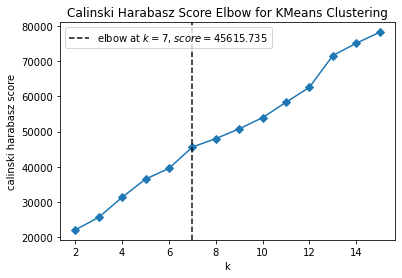

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [148]:
model = KElbowVisualizer(KMeans(), k=15, metric='calinski_harabasz', timings=False)
model.fit(comp_star.rename(columns = {0: '0'}))
model.show()

In [149]:
# Reset matplotlib parameters, changed by elbow visualizer
mpl.rcParams.update(mpl.rcParamsDefault)

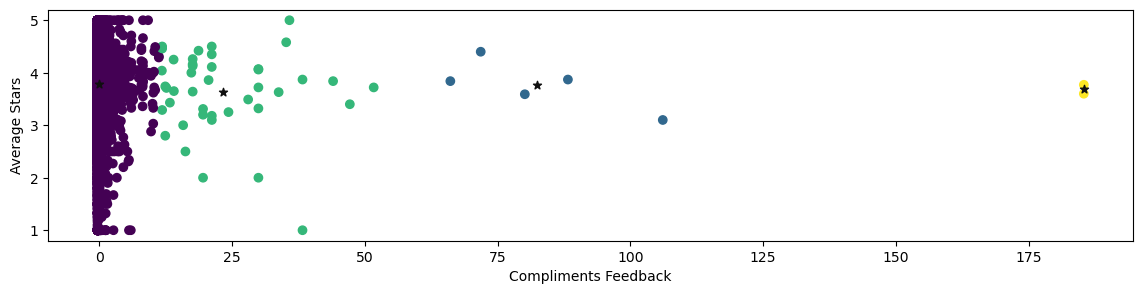

In [150]:
model = KMeans(n_clusters=4) # although elbow plot suggests 7, clusters for 4 will be better for visualization
model.fit(comp_star.rename(columns = {0: '0'}))
all_predictions = model.predict(comp_star.rename(columns = {0: '0'}))
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(comp_star.iloc[:,0].values, comp_star.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Compliments Feedback')
plt.ylabel('Average Stars')
plt.show()

#### Findings

- Based on number of compliments feedback, label the users as low_complimented, occational_complimented, moderately_complimented, highly_complimented

- low_complimented users with low count of compliments_feedback, rate across the spectrum of average ratings, but mostly staying at the center (3.5-4 avg).
- occational/moderately_complimented users, who have a higher numder of compliments, rate in a stricter margin of 3-4 star avg rating, with majority at 3+, which means users with moderate compliments, rate more highly on average.
- highly_complimented users, are low in numbers, as opposed to others, and if we assume their sample sparsity is representative of the population, then we can say they also on average rate at about 4 stars.

- If a user has moderate compliments, then we can expect them to show a tight variance of high avg ratings

In [151]:
# number of elements in each cluster
from collections import Counter
Counter(model.labels_)

Counter({0: 14367, 3: 2, 2: 42, 1: 5})

/Users/zhanglinyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


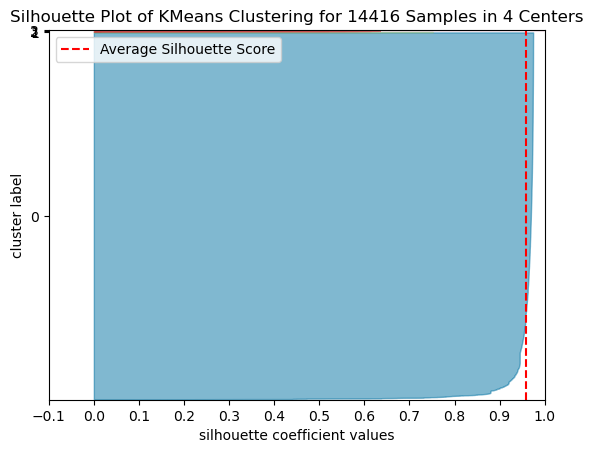

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 14416 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [152]:
# Silhouette plot
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(comp_star.rename(columns = {0: '0'}))
visualizer.show()

The plot shows most of the points are in cluster 0, with an average silhouette values of 0.85

### Bisecting K-Means

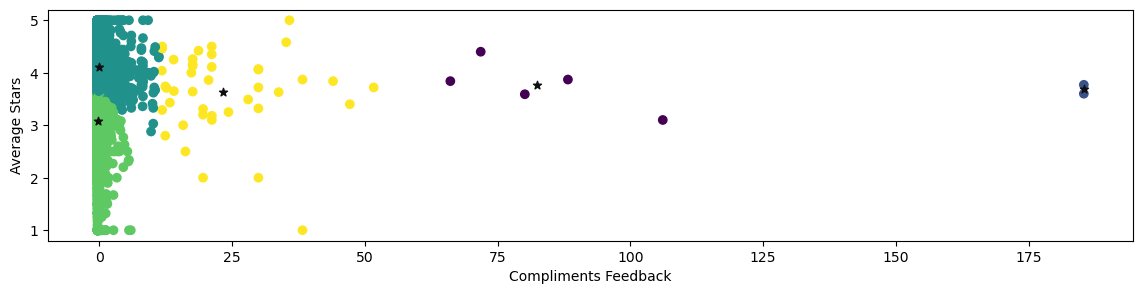

In [153]:
bkm = BisectingKMeans(n_clusters=5).fit(comp_star.rename(columns = {0: '0'}))
all_predictions = bkm.predict(comp_star.rename(columns = {0: '0'}))
centroids = bkm.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(comp_star.iloc[:,0].values, comp_star.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Compliments Feedback')
plt.ylabel('Average Stars')
plt.show()

In [154]:
# number of elements in each cluster
Counter(bkm.labels_)

Counter({2: 9995, 3: 4372, 1: 2, 4: 42, 0: 5})

/Users/zhanglinyue/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BisectingKMeans was fitted with feature names
  warnings.warn(


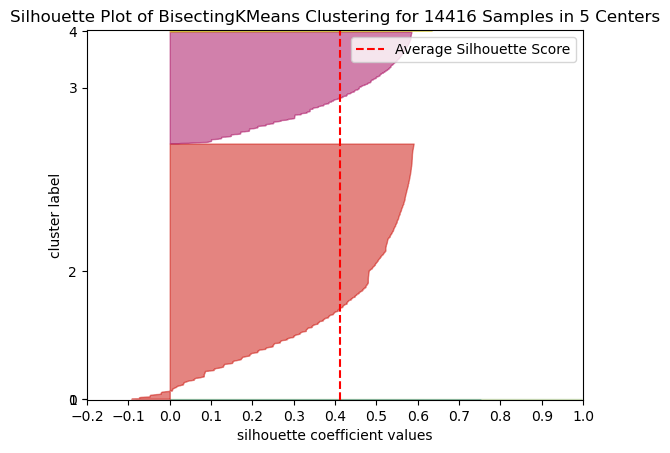

<AxesSubplot:title={'center':'Silhouette Plot of BisectingKMeans Clustering for 14416 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [155]:
# Silhouette plot
visualizer = SilhouetteVisualizer(bkm, colors='yellowbrick')
visualizer.fit(comp_star.rename(columns = {0: '0'}))
visualizer.show()

#### Findings

- Compared with K-means, Bisecting K-Means suggests divide the users with occasional compliments into two groups, one with lower average rating stars and one with higher average rating stars. This is reasonal because users who have low compliments can have different rating behaviors. 
- The silhouette plot shows there are two dominant groups, but the average silhouette values are lower than the K-means method.

### DBSCAN

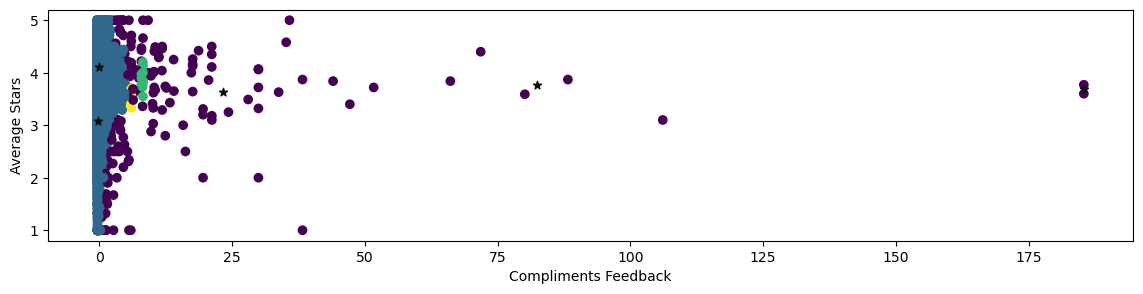

In [156]:
dbscan = DBSCAN(eps=0.25, min_samples=5)
dbscan.fit(comp_star.rename(columns = {0: '0'}))

plt.figure(figsize=(14, 3))
plt.scatter(comp_star.iloc[:,0].values, comp_star.iloc[:,1].values, c=dbscan.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='#0f0f0f')
plt.xlabel('Compliments Feedback')
plt.ylabel('Average Stars')
plt.show()

In [157]:
# check unique clusters
set(dbscan.labels_)

{-1, 0, 1, 2}

In [158]:
# number of elements in each cluster
Counter(dbscan.labels_)

Counter({0: 14238, -1: 158, 1: 13, 2: 7})

In [159]:
# print the silhouette value
value_sil = metrics.silhouette_score(comp_star, dbscan.labels_)
print('Silhouette value:', value_sil)

Silhouette value: 0.8428701883895624


The performance for DBSCAN is quite similar to K-means. The silhouette value is almost the same. The difference is that DBSCAN suggests 4 clusters, with the most points are in the users with occasional compliments group.

## Recommendation Engine

**Data preprocessing**

In [52]:
pd.set_option('display.max_columns', None)
# getting the dataframe containing only open restautants in Philadelphia
df2 = df.copy()
df2.head()

,index,business_id,business_name,address,city,state,postal_code,latitude,longitude,business_stars,review_count_business,is_open,attributes,categories,hours,review_id,user_id,stars,useful,funny,cool,text,date,name,review_count_user,yelping_since,useful_user,funny_user,cool_user,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,3,kxX2SOes4o-D3ZQBkiMRfA,Zaika,2481 Grant Ave,Philadelphia,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21...",AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Kyle,9.0,2014-01-17 19:20:57,1.0,0.0,1.0,,None,0.0,4.78,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16,YtSqYv1Q_pOltsVPSx54SA,Rittenhouse Grill,1701 Locust St,Philadelphia,PA,19103,39.948949,-75.169532,3.5,290,1,"{'RestaurantsAttire': 'u'dressy'', 'Restaurant...","Wine Bars, Restaurants, Nightlife, Steakhouses...","{'Wednesday': '16:30-22:0', 'Thursday': '16:30...",oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,5,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,Jack,2.0,2013-05-26 02:27:11,3.0,2.0,1.0,,_ISwgxjUZm8hFIU-53UsDQ,0.0,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,19,eFvzHawVJofxSnD7TgbZtg,Good Karma Cafe,928 Pine St,Philadelphia,PA,19107,39.944609,-75.157833,4.0,249,1,"{'Alcohol': 'u'none'', 'RestaurantsReservation...","Food, Cafes, Coffee & Tea, Restaurants","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,5,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,Dana,182.0,2010-02-22 16:15:28,217.0,33.0,40.0,2018,"YTDadrj2g1BrGsxcyQ0Kew, CKf0U33HQlUIG62yufzH7A...",6.0,3.41,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,4.0,0.0,0.0
5,38,kq5Ghhh14r-eCxlVmlyd8w,The Coventry Deli,2000 Market St,Philadelphia,PA,19103,39.953291,-75.173645,4.0,65,1,"{'Corkage': 'False', 'BusinessAcceptsCreditCar...","Restaurants, Delis, Salad, Sandwiches","{'Monday': '6:0-15:0', 'Tuesday': '6:0-15:0', ...",JBWZmBy69VMggxj3eYn17Q,aFa96pz67TwOFu4Weq5Agg,5,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38,Jenna,84.0,2017-07-07 00:33:21,75.0,7.0,38.0,"2019,20,20,2021","Na1v6n6Mqk7KEzSrpIBaJQ, C4gTLF6pDNFkx2Qpn24aSg...",5.0,3.93,1.0,0.0,1.0,0.0,0.0,7.0,3.0,3.0,3.0,1.0,5.0
6,42,oBhJuukGRqPVvYBfTkhuZA,Square 1682,121 S 17th St,Philadelphia,PA,19103,39.950801,-75.168611,3.5,385,1,"{'RestaurantsPriceRange2': '2', 'Alcohol': 'u'...","American (New), Breakfast & Brunch, Bars, Nigh...","{'Monday': '0:0-0:0', 'Tuesday': '17:0-22:0', ...",YcLXh-3UC9y6YFAI9xxzPQ,G0DHgkSsDozqUPWtlxVEMw,4,0,0,0,The only reason I didn't give this restaurant ...,2015-03-05 03:37:54,Aaron,68.0,2010-10-27 20:57:03,72.0,14.0,10.0,"2015,2016","hkU-eNQgqjPaBxp0dCNSew, eSkdLAIJv9AP25dHfgseNA...",2.0,3.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [53]:
df2.columns

Index(['index', 'business_id', 'business_name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_stars',
       'review_count_business', 'is_open', 'attributes', 'categories', 'hours',
       'review_id', 'user_id', 'stars', 'useful', 'funny', 'cool', 'text',
       'date', 'name', 'review_count_user', 'yelping_since', 'useful_user',
       'funny_user', 'cool_user', 'elite', 'friends', 'fans', 'average_stars',
       'compliment_hot', 'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos'],
      dtype='object')

In [54]:
## keep the needed columns for future analysis
df_rec=df2[['user_id','stars','date','business_id','business_name','business_stars','address']]
df_rec.head()

,user_id,stars,date,business_id,business_name,business_stars,address
0,_7bHUi9Uuf5__HHc_Q8guQ,5,2015-01-04 00:01:03,kxX2SOes4o-D3ZQBkiMRfA,Zaika,4.0,2481 Grant Ave
3,Dd1jQj7S-BFGqRbApFzCFw,5,2013-06-24 11:21:25,YtSqYv1Q_pOltsVPSx54SA,Rittenhouse Grill,3.5,1701 Locust St
4,IQsF3Rc6IgCzjVV9DE8KXg,5,2014-11-12 15:30:27,eFvzHawVJofxSnD7TgbZtg,Good Karma Cafe,4.0,928 Pine St
5,aFa96pz67TwOFu4Weq5Agg,5,2018-08-23 21:39:38,kq5Ghhh14r-eCxlVmlyd8w,The Coventry Deli,4.0,2000 Market St
6,G0DHgkSsDozqUPWtlxVEMw,4,2015-03-05 03:37:54,oBhJuukGRqPVvYBfTkhuZA,Square 1682,3.5,121 S 17th St


In [55]:
df_rec.shape

(37503, 7)

## 1. Popularity Based Recommender
Pick the most popular restaurant (rated highly) among the users and directly recommend those

In [56]:
# Getting the 10 most popular restaurants based on stars.
df_rec.groupby('business_name')['stars'].count().sort_values(ascending=False).head(10)


business_name
Village Whiskey        1342
Honey's Sit-N-Eat      1213
Penang                  938
HipCityVeg              934
El Camino Real          912
Khyber Pass Pub         761
Federal Donuts          706
Tria Cafe Wash West     687
Han Dynasty             658
Suraya                  630
Name: stars, dtype: int64

In [57]:
# getting the details of the most restaurant
most_popular = df_rec[df_rec['business_name']=='Village Whiskey'][['business_name','address','business_stars']].iloc[:1]
most_popular


,business_name,address,business_stars
7,Village Whiskey,118 S 20th St,4.0


In [58]:
# getting the details of the most restaurant
pd.set_option("display.max_colwidth", -1)
most_popular = df_new[df_rec['business_name']=='Village Whiskey'][['business_name', 'address', 'postal_code', 'business_stars',
       'review_count_business',  'categories', 'hours']].iloc[:1]
most_popular

/var/folders/lp/82840zd14mgc4dpzfxwwy1cm0000gn/T/ipykernel_83425/3145135271.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


,business_name,address,postal_code,business_stars,review_count_business,categories,hours
7,Village Whiskey,118 S 20th St,19103,4.0,1553,"Bars, Nightlife, Whiskey Bars, Burgers, Restaurants, American (New)","{'Wednesday': '16:0-21:0', 'Thursday': '16:0-21:0', 'Friday': '16:0-22:0', 'Saturday': '12:0-22:0', 'Sunday': '12:0-21:0'}"


## 2. Collaboritive Filtering

In [59]:
# Build the user-item matrix
user_item = pd.pivot_table(data=df_rec, values='stars', index='user_id', columns='business_name',fill_value=0)
#user_item.replace('',np.nan,inplace=True) 
user_item.head()

business_name,1 Stop Pizza,16th Street Seafood,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Grill Mexican Restaurant,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Angelina's,Ants Pants Café,Applebee's Grill + Bar,Arby's,Arbys Roast Beef,Asadero los tios,Asian Garden,Athenian Restaurant,Authentic LanZhou Handpulled Noodles,Axis Pizza,Aya's Pizza,B&B Breakfast and Lunch,BAP,Bai Wei,Baltic Bakery,Beck's Cajun Cafe,Big Geez Chicken Shack,Bistro La Baia,Bitar's,Bold Coffee Bar,Bonks Bar,Boom Buns,Boostin' Bowls,Boricua Restaurant,Bourbon & Branch,Bread & Butter Philly - Breakfast Junction,Breakfast Boutique Chestnut Hill,Bridesburg Pizza,Brown Sugar Bakery & Cafe,Buena Onda,Bui's,Burger King,Burger Lane,Burrito Bonito,Butter's Soul Food,Cactus Restaurant & Bar,Cafe Square One,Cake Life Bake Shop,Capital Beer,Cedar Park Cafe,Chan's Halal Restaurant,Charlie's Roast Pork,Chase's Hop Shop,Checkers,Chef Joseph Poon,Cherry Lounge,Chick-fil-A,Chickie's & Pete's,China House,Chuck E. Cheese,Chuck's Alibi,Cily Chicken Rice,Cleopatra Cafe,Cloud Factory Hookah Lounge,Convenient Food Mart,Copabanana,Craft Hall,Crazy Sushi,Crown Fried Chicken,Cucina Zapata,D'S Caribbean And American Food,DK Sushi,Dagwood's Pub,Day Break Eggs,Domino's Pizza,Don Panchito Mexican Grill,Dragon House,Dunkin',Earl of Sandwich,Ed's Pizza House,El Camino Real,El Limon,Essene Market & Café,Fabio's Chicken Restaurant Takeout,Falls Deli,Federal Donuts,Feltonville Express Pizza,Fez Moroccon Restaurant,Flambo Caribbean Restaurant,Flannel,Foodery,Foods On First,Forin Cafe,Fortune Chinese Restaurant,Frank's Spaghetti House,Franklin's,Franny Lou's Porch,Franzone's Pizzeria & Restaurant,Fresh Gulf Seafood,Gaby’s Station Pizza,Gachi Sushi and Noodle,Gaetano’s,George's Sandwich Shop,George's Wings,Gigi and Big R,Giovanni's Pizzeria,Golden China Wok Restaurant,Golden Chopstick Chinese Restaurant,Golden Triangle,Goldie,Good Karma Cafe,Goody's Pizza,Goree,Green Basil Thai Kitchen,Green Eggs Cafe,Greenman's Deli,Guavaberry Foods & Drinks,Halal Gyro King,Hammerheads Bar & Grille,Han Dynasty,Happy Joy Family Restaurant,Happy Panda,Hibachi 2 Go,HipCityVeg,HipCityVeg - University City,Holmesburg Bakery,Honey's Sit-N-Eat,Hong Kong Chinese Restaurant,Hunnies Crispy Chicken,Hyon's Seafood,In & Out Pizza,In the Valley,Ippolito's Seafood,Italiano's,Izzy's 33,J'aime French Bakery,JD's Soul Food Kitchen,Jade Palace,Jamaican Jerk Hut,Jasmine Rice - Rittenhouse,Jeisy Grilled Chicken,Joe's Steaks + Soda Shop,John's Seafood,Jong Ka Jib,Junes Breakfast,Justin's Snack Corner,KASUMI SUSHI,KFC,Kato's Cajun,Ken's Seafood Restaurant,Khyber Pass Pub,King's Garden,Kumo Hibachi Sushi,Kurry Shack,La Colombe Coffee,La Esquina del Bronco,La Marqueza - Food Truck,Larry's Steaks,Las Cazuelas Restaurant BYOB,Lazos Pizza & Grill,Lee How Fook,Lee's Breakfast,Lemoncello Restaurant Philly,Lincoln Chicken Pizza And Grill,Little Caesars Pizza,Little Kitchen,Lloyd Whiskey Bar,Loco Lucho's Latino Kitchen,Loews Philadelphia Hotel,Lombard Swim Club,Los Compadres,Los Potrillos,Lucky Wok Restaurant,Mac Mart,Mac's Tavern,Marathon,Maria's Ristorante on Summit,Marmont Steakhouse & Bar,Marrakesh,Mary's Lunch,Master Wok,Mayfair Pizza,Mayura Indian Restaurant,McDonald's,Mediterra Grill,MexiCali,Mexican Grill Stand,Mike's Breakfast,Mike's Hot Dog Cart,Minas Pizza,Misconduct Tavern,Mom Mom's Kitchen and Polish Food Cart,Mom's Seafood,Mommy Telly's Famous BBQ,Mood Cafe,Moon Flower House,Moy Fong Restaurant,Murph's Bar,México Lindo,NY Bagel & Deli Shop,New England Pizza,New Lee's Chinese Restaurant,New Napoli Famous Pizza,New Number One Chinese Restaurant,New Tavern Bar,Night Market,Non Stop Pizza & Grille,O Sole Mio,Octopus Falafel Truck,Olde City Food Market,Olly,Orchard Smoothie and Cafe,Oregon Steaks,Oteri's Italian Bakery | North 5th St,Otolith Sustainable Seafood,P & S Ravioli,Panasian Buffe

In [60]:
# Normalize user-item matrix
user_item_norm = user_item.subtract(user_item.mean(axis=1), axis = 0)
user_item_norm.head()

business_name,1 Stop Pizza,16th Street Seafood,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Grill Mexican Restaurant,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Angelina's,Ants Pants Café,Applebee's Grill + Bar,Arby's,Arbys Roast Beef,Asadero los tios,Asian Garden,Athenian Restaurant,Authentic LanZhou Handpulled Noodles,Axis Pizza,Aya's Pizza,B&B Breakfast and Lunch,BAP,Bai Wei,Baltic Bakery,Beck's Cajun Cafe,Big Geez Chicken Shack,Bistro La Baia,Bitar's,Bold Coffee Bar,Bonks Bar,Boom Buns,Boostin' Bowls,Boricua Restaurant,Bourbon & Branch,Bread & Butter Philly - Breakfast Junction,Breakfast Boutique Chestnut Hill,Bridesburg Pizza,Brown Sugar Bakery & Cafe,Buena Onda,Bui's,Burger King,Burger Lane,Burrito Bonito,Butter's Soul Food,Cactus Restaurant & Bar,Cafe Square One,Cake Life Bake Shop,Capital Beer,Cedar Park Cafe,Chan's Halal Restaurant,Charlie's Roast Pork,Chase's Hop Shop,Checkers,Chef Joseph Poon,Cherry Lounge,Chick-fil-A,Chickie's & Pete's,China House,Chuck E. Cheese,Chuck's Alibi,Cily Chicken Rice,Cleopatra Cafe,Cloud Factory Hookah Lounge,Convenient Food Mart,Copabanana,Craft Hall,Crazy Sushi,Crown Fried Chicken,Cucina Zapata,D'S Caribbean And American Food,DK Sushi,Dagwood's Pub,Day Break Eggs,Domino's Pizza,Don Panchito Mexican Grill,Dragon House,Dunkin',Earl of Sandwich,Ed's Pizza House,El Camino Real,El Limon,Essene Market & Café,Fabio's Chicken Restaurant Takeout,Falls Deli,Federal Donuts,Feltonville Express Pizza,Fez Moroccon Restaurant,Flambo Caribbean Restaurant,Flannel,Foodery,Foods On First,Forin Cafe,Fortune Chinese Restaurant,Frank's Spaghetti House,Franklin's,Franny Lou's Porch,Franzone's Pizzeria & Restaurant,Fresh Gulf Seafood,Gaby’s Station Pizza,Gachi Sushi and Noodle,Gaetano’s,George's Sandwich Shop,George's Wings,Gigi and Big R,Giovanni's Pizzeria,Golden China Wok Restaurant,Golden Chopstick Chinese Restaurant,Golden Triangle,Goldie,Good Karma Cafe,Goody's Pizza,Goree,Green Basil Thai Kitchen,Green Eggs Cafe,Greenman's Deli,Guavaberry Foods & Drinks,Halal Gyro King,Hammerheads Bar & Grille,Han Dynasty,Happy Joy Family Restaurant,Happy Panda,Hibachi 2 Go,HipCityVeg,HipCityVeg - University City,Holmesburg Bakery,Honey's Sit-N-Eat,Hong Kong Chinese Restaurant,Hunnies Crispy Chicken,Hyon's Seafood,In & Out Pizza,In the Valley,Ippolito's Seafood,Italiano's,Izzy's 33,J'aime French Bakery,JD's Soul Food Kitchen,Jade Palace,Jamaican Jerk Hut,Jasmine Rice - Rittenhouse,Jeisy Grilled Chicken,Joe's Steaks + Soda Shop,John's Seafood,Jong Ka Jib,Junes Breakfast,Justin's Snack Corner,KASUMI SUSHI,KFC,Kato's Cajun,Ken's Seafood Restaurant,Khyber Pass Pub,King's Garden,Kumo Hibachi Sushi,Kurry Shack,La Colombe Coffee,La Esquina del Bronco,La Marqueza - Food Truck,Larry's Steaks,Las Cazuelas Restaurant BYOB,Lazos Pizza & Grill,Lee How Fook,Lee's Breakfast,Lemoncello Restaurant Philly,Lincoln Chicken Pizza And Grill,Little Caesars Pizza,Little Kitchen,Lloyd Whiskey Bar,Loco Lucho's Latino Kitchen,Loews Philadelphia Hotel,Lombard Swim Club,Los Compadres,Los Potrillos,Lucky Wok Restaurant,Mac Mart,Mac's Tavern,Marathon,Maria's Ristorante on Summit,Marmont Steakhouse & Bar,Marrakesh,Mary's Lunch,Master Wok,Mayfair Pizza,Mayura Indian Restaurant,McDonald's,Mediterra Grill,MexiCali,Mexican Grill Stand,Mike's Breakfast,Mike's Hot Dog Cart,Minas Pizza,Misconduct Tavern,Mom Mom's Kitchen and Polish Food Cart,Mom's Seafood,Mommy Telly's Famous BBQ,Mood Cafe,Moon Flower House,Moy Fong Restaurant,Murph's Bar,México Lindo,NY Bagel & Deli Shop,New England Pizza,New Lee's Chinese Restaurant,New Napoli Famous Pizza,New Number One Chinese Restaurant,New Tavern Bar,Night Market,Non Stop Pizza & Grille,O Sole Mio,Octopus Falafel Truck,Olde City Food Market,Olly,Orchard Smoothie and Cafe,Oregon Steaks,Oteri's Italian Bakery | North 5th St,Otolith Sustainable Seafood,P & S Ravioli,Panasian Buffe

In [61]:
# User similarity matrix using Pearson correlation
tic = time.time()
user_similarity = user_item_norm.T.corr(method='pearson')
user_similarity.head()
toc = time.time()
print(f"Time taken to process user similarity is {round(toc-tic, 2)} seconds")

Time taken to process user similarity is 409.21 seconds


In [62]:
# Item similarity matrix using Pearson correlation
tic = time.time()
item_similarity = user_item_norm.corr(method='pearson')
item_similarity.head()
toc = time.time()
print(f"Time taken to process user similarity is {round(toc-tic, 2)} seconds")

Time taken to process user similarity is 5.29 seconds


In [63]:
# # Pick a user ID
target_userid = '--4AjktZiHowEIBCMd4CZA' 

# # Pick a book
target_bookid = 'Penang'

# # Books that the target user has rated
target_userid_rated = pd.DataFrame(user_item_norm.loc[[target_userid]].dropna(axis=1, how='all')).reset_index()
target_userid_rated.drop(target_userid_rated.iloc[:, 0:1], inplace=True, axis=1)
target_userid_rated = target_userid_rated.T

In [64]:
__temp = user_item_norm[target_bookid].dropna().reset_index()
temp_dict = {}
for custid, val in zip(__temp.user_id.values, __temp[target_bookid].values):
    temp_dict[custid] = val
target_bookid_rated = pd.DataFrame(temp_dict, index = [0])
target_bookid_rated.index.rename('user_id', inplace = True)
target_bookid_rated = target_bookid_rated.T

In [65]:
# # Similarity score of targetuserid with all the other users
target_user_similarity_score = user_similarity.loc[[target_userid]].dropna(axis=1, how='all').reset_index()
target_user_similarity_score.drop(target_user_similarity_score.iloc[:, 0:1], inplace=True, axis=1)
target_user_similarity_score = target_user_similarity_score.T
target_user_similarity_score.head()

,0
user_id,
--4AjktZiHowEIBCMd4CZA,1.000000
--6PFZka7og6Khaw6oyjvQ,-0.004141
--9SwR3jQX-e3opxARFF_g,-0.004141
--S8M395r8NtOCvS2LRfDw,-0.004141
--UizzbnQlZg7bEv2oXEyg,-0.004141


In [66]:
# # Similarity score of the target_bookid with all the other businesses
target_book_similarity_score = item_similarity.loc[[target_bookid]].dropna(axis=1, how='all').reset_index()
target_book_similarity_score.drop(target_book_similarity_score.iloc[:, 0:1], inplace=True, axis=1)
target_book_similarity_score = target_book_similarity_score.T
target_book_similarity_score.head()

,0
business_name,
1 Stop Pizza,-0.045002
16th Street Seafood,-0.077028
1st NE International Market,-0.044223
2 in One Cafe,-0.052308
3J's Food Market,-0.017013


In [67]:
# #Rank the similarities
target_book_similarity = target_book_similarity_score.sort_values(by = [(0)], ascending = False)
target_user_similarity = target_user_similarity_score.sort_values(by = [(0)], ascending = False)

In [68]:
target_book_similarity = target_book_similarity.iloc[1:, :] # Drop the first row as it is the product and user itself therefore the max score of 1.00
target_user_similarity = target_user_similarity.drop(target_userid, axis = 0)

In [69]:
# #Rank the similarities between target user and target book
target_userid_rated_similarity = target_book_similarity#select top 5

In [70]:
target_bookid_rated_similarity = target_user_similarity

In [71]:
target_book_similarity = target_book_similarity.rename(columns = {(0) : ('similarity_score_restaurant')})

In [72]:
target_book_similarity.head()

,similarity_score_restaurant
business_name,
Jong Ka Jib,0.036291
Cucina Zapata,0.028879
Marrakesh,0.022528
Southgate,0.021244
Bui's,0.021157


In [73]:
target_user_similarity = target_user_similarity.rename(columns = {(0) : ('similarity_score_user')})

In [74]:
target_user_similarity

,similarity_score_user
user_id,
dIKGGMYW2SocsGVqp2ZXCg,1.000000
IvqYQzNwEi5KeWcJfZB_gA,1.000000
nYkTnl4jNV7vNm7Qni5q5Q,1.000000
7mzo8uYToyTkdl4kpAsgiQ,0.948405
R1jMkYQc-CsUXQgQsOXuFA,0.914182
...,...
wABHp4fGUC-0acRKhmQO2A,-0.017714
IKbjLnfBQtEyVzEu8CuOLg,-0.018101
hQjN1FuYaB4pQACZwfrclw,-0.019680


In [75]:
business_reviews_user[['business_name', 'user_id', 'stars']]

,business_name,user_id,stars
0,Turning Point of North Wales,mh_-eMZ6K5RLWhZyISBhwA,3
1,Body Cycle Spinning Studio,OyoGAe7OKpv6SyGZT5g77Q,5
2,Kettle Restaurant,8g_iMtfSiwikVnbP2etR0A,3
3,Zaika,_7bHUi9Uuf5__HHc_Q8guQ,5
4,Melt,bcjbaE6dDog4jkNY91ncLQ,4
...,...,...,...
499995,Spike's Trophies,tCPzvPwsd_DwBx6whsDlLQ,5
499996,Manzanita Gate Apartments,rj0uSTXu1rPVgAfOMHYltQ,5
499997,Crown Candy Kitchen,MVqzYt-E7y1Mdw9F_7nLjw,4
499998,Nirvana Indian Bistro,vn777Y2vCynYYUYJjNYdYg,2


In [76]:
target_userid_rated_similarity = pd.merge(pd.merge(pd.merge(business_reviews_user[['business_name', 'user_id', 'stars']], business_reviews_user.groupby('business_name').agg({'review_id': ['count'], 'average_stars': ['mean']}), how = 'left', left_on = 'business_name', right_index = True).rename(columns = {('review_id', 'count'): 'count', ('average_stars', 'mean'): 'mean_stars'}), target_book_similarity, how = 'right', left_on = 'business_name', right_index = True), target_user_similarity, left_on = 'user_id', right_index = True)

/var/folders/lp/82840zd14mgc4dpzfxwwy1cm0000gn/T/ipykernel_83425/793766229.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  target_userid_rated_similarity = pd.merge(pd.merge(pd.merge(business_reviews_user[['business_name', 'user_id', 'stars']], business_reviews_user.groupby('business_name').agg({'review_id': ['count'], 'average_stars': ['mean']}), how = 'left', left_on = 'business_name', right_index = True).rename(columns = {('review_id', 'count'): 'count', ('average_stars', 'mean'): 'mean_stars'}), target_book_similarity, how = 'right', left_on = 'business_name', right_index = True), target_user_similarity, left_on = 'user_id', right_index = True)


In [77]:
target_userid_rated_similarity

,business_name,user_id,stars,count,mean_stars,similarity_score_restaurant,similarity_score_user
338,Jong Ka Jib,QuZKJnltihmZ8jhwfxPeJA,5,291,3.835862,0.036291,-0.009838
450977,Federal Donuts,QuZKJnltihmZ8jhwfxPeJA,4,706,3.792656,0.006220,-0.009838
175632,Honey's Sit-N-Eat,QuZKJnltihmZ8jhwfxPeJA,5,1213,3.837254,-0.000818,-0.009838
263071,Tria Cafe Wash West,QuZKJnltihmZ8jhwfxPeJA,4,687,3.868600,-0.000885,-0.009838
11209,El Camino Real,QuZKJnltihmZ8jhwfxPeJA,3,912,3.694311,-0.004064,-0.009838
...,...,...,...,...,...,...,...
423863,Paradise Pizzeria,ufOSqMYZ7W9w2a-uGqdmQQ,1,3,NaN,-0.138674,-0.004141
479303,Paradise Pizzeria,kVQHTSp2YU6Mpka6ZCrPZQ,1,3,NaN,-0.138674,-0.004141
494086,Paradise Pizzeria,mZNQFoMB0jPid943CNwATQ,1,3,NaN,-0.138674,-0.004141
356313,D'S Caribbean And American Food,tfcjLc2vYQ2HmXpQ8vNUWw,1,2,NaN,-0.146718,-0.004141


Giving weight of 0.65 for user similarity and 0.35 to item similarity. We are giving more weights to the users

In [78]:
target_userid_rated_similarity['overall_similairty'] = target_userid_rated_similarity['similarity_score_restaurant'] * 0.35 + target_userid_rated_similarity['similarity_score_user'] * 0.65
target_userid_rated_similarity = target_userid_rated_similarity.sort_values(by = ['overall_similairty'], ascending = False)

In [79]:
target_userid_rated_similarity[['similarity_score_user', 'similarity_score_restaurant', 'overall_similairty']]

,similarity_score_user,similarity_score_restaurant,overall_similairty
90364,1.000000,0.007086,0.652480
83215,1.000000,0.007086,0.652480
214459,1.000000,0.007086,0.652480
127725,1.000000,-0.002706,0.649053
334472,1.000000,-0.002706,0.649053
...,...,...,...
423863,-0.004141,-0.138674,-0.051228
479303,-0.004141,-0.138674,-0.051228
494086,-0.004141,-0.138674,-0.051228
356313,-0.004141,-0.146718,-0.054043


In [80]:
# #Calculate the predicted rating using weighted average of similarity
target_userid_rated_similarity = target_userid_rated_similarity.dropna() # Dropping few NaNs
predicted_rating = round(np.average(target_userid_rated_similarity['mean_stars'], 
                                    weights=target_userid_rated_similarity['overall_similairty']), 6)
print(f'The predicted rating for the restaurant "{target_bookid}"\n by user {target_userid} is {predicted_rating}' )

The predicted rating for the restaurant "Penang"
 by user --4AjktZiHowEIBCMd4CZA is 3.809361


## SVD

In [81]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split

In [82]:
# Get minimum and maximum rating from the dataset
min_rating = df_rec['stars'].min()
max_rating = df_rec['stars'].max()
 
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df_rec[['user_id', 'business_id', 'stars']], reader)

### Matrix Factorization

In [83]:
svd = SVD(n_epochs=10)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1797  1.1700  1.1497  1.1498  1.1851  1.1460  1.1665  1.1604  1.1853  1.1665  1.1659  0.0138  
MAE (testset)     0.9217  0.9252  0.9108  0.9014  0.9353  0.9097  0.9190  0.9149  0.9292  0.9150  0.9182  0.0095  
Fit time          0.19    0.18    0.18    0.19    0.18    0.18    0.19    0.18    0.19    0.19    0.18    0.00    
Test time         0.15    0.01    0.01    0.01    0.01    0.01    0.02    0.01    0.02    0.01    0.03    0.04    


In [84]:
print("Average MAE: ", np.average(results["test_mae"]))
print("Average RMSE: ", np.average(results["test_rmse"]))

Average MAE:  0.9182240125241687
Average RMSE:  1.165881655081673


### Hyperparameter Tuning

In [85]:
param_grid = {
  'n_factors': [20, 50, 100],
  'n_epochs': [5, 10, 20]
}
 
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=10)
gs.fit(data)
 
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.1601510710436425
{'n_factors': 20, 'n_epochs': 20}


In [86]:
# best hyperparameters
best_factor = gs.best_params['rmse']['n_factors']
best_epoch = gs.best_params['rmse']['n_epochs']
 
# sample random trainset and testset
# test set is made of 20% of the ratings.
trainset, testset = train_test_split(data, test_size=.20)
 
# We'll use the famous SVD algorithm.
svd = SVD(n_factors=best_factor, n_epochs=best_epoch)
 
# Train the algorithm on the trainset
svd.fit(trainset)

### Recommendation

In [87]:
def generate_recommendation(model, user_id, ratings_df, books_df, n_items):
    
    # Get a list of all items from dataset
    book_ids = ratings_df["business_id"].unique()
 
    # Get a list of all items that have been rated by user
    book_ids_user = ratings_df.loc[ratings_df["user_id"] == user_id, "business_id"]
    
    # Get a list off all items that that have not been not rated by user
    book_ids_to_pred = np.setdiff1d(book_ids, book_ids_user)
 
    # Apply a rating of 4 to all interactions (only to match the Surprise dataset format)
    test_set = [[user_id, book_id, 4] for book_id in book_ids_to_pred]
 
    # Predict the ratings and generate recommendations
    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions])
    print("Top {0} restaurant recommendations for user {1}:\n".format(n_items, user_id))
    
    # Rank top-n items based on the predicted ratings
    index_max = (-pred_ratings).argsort()[:n_items]
    for i in index_max:
        book_id = book_ids_to_pred[i]
        print(books_df[books_df["business_id"]==book_id]["business_name"].values[0], pred_ratings[i])
 

In [88]:
# define which user ID that we want to give recommendation
user_id = '_7bHUi9Uuf5__HHc_Q8guQ' 

# define how many top-n movies that we want to recommend
n_items = 10

# generate recommendation using the model that we have trained
generate_recommendation(svd,user_id,df_rec,df_rec,n_items)

Top 10 restaurant recommendations for user _7bHUi9Uuf5__HHc_Q8guQ:

México Lindo 4.8467815185287515
Mom Mom's Kitchen and Polish Food Cart 4.840801581237635
Octopus Falafel Truck 4.80965336108923
J'aime French Bakery 4.803254465917255
Tomo Sushi & Ramen 4.799266636985539
Vineyards Cafe 4.798398894919267
SALERNO'S Ristorante & Pizzeria 4.707931906723849
SPOT Gourmet Burgers 4.685372918547967
Italiano's 4.6766406206987075
Angelina's 4.674277246807145


In [89]:
# define which user ID that we want to give recommendation
user_id = 'aFa96pz67TwOFu4Weq5Agg' 

# define how many top-n movies that we want to recommend
n_items = 10

# generate recommendation using the model that we have trained
generate_recommendation(svd,user_id,df_rec,df_rec,n_items)

Top 10 restaurant recommendations for user aFa96pz67TwOFu4Weq5Agg:

Vineyards Cafe 4.8591668686415135
México Lindo 4.804373395139308
Octopus Falafel Truck 4.798249943323497
Mom Mom's Kitchen and Polish Food Cart 4.777247510597645
Mood Cafe 4.752821609640358
Italiano's 4.744059479248896
J'aime French Bakery 4.683617177908175
Angelina's 4.651555477141979
Tomo Sushi & Ramen 4.646959782782198
Vientiane Bistro 4.63063109864684


## RFM analysis for reviewers

The most helpful and active reviewers' reviews hold more weightage

In [114]:
rfm_data = business_reviews_user.groupby('user_id').agg({'review_id': ['count'], 'yelping_since': ['min'], 'useful_user': ['sum'], 'funny_user': ['sum'], 'cool_user': ['sum'], 'fans': ['sum'], 'average_stars': ['mean'], 'date': ['max']})

In [115]:
rfm_data.head(5)

,review_id,yelping_since,useful_user,funny_user,cool_user,fans,average_stars,date
,count,min,sum,sum,sum,sum,mean,max
user_id,,,,,,,,
---2PmXbF47D870stH1jqA,3,2012-10-24 13:20:46,189.0,12.0,108.0,9.0,4.98,2015-06-27 23:38:13
---UgP94gokyCDuB5zUssA,2,2014-11-02 14:53:16,16.0,0.0,6.0,2.0,3.44,2014-11-10 02:49:07
---r61b7EpVPkb4UVme5tA,1,2013-02-07 00:35:37,10.0,2.0,3.0,1.0,4.17,2014-05-06 14:00:28
--2bpE5vyR-2hAP7sZZ4lA,2,2015-10-12 01:29:20,16.0,4.0,2.0,2.0,4.20,2015-12-18 17:43:01
--2tyArRmSoyKx5r-FVG0A,1,NaN,0.0,0.0,0.0,0.0,NaN,2012-06-25 18:57:28


In [116]:
rfm_data.shape # 318k users and their associated data to make a RFM table

(318303, 8)

In [117]:
rfm_data.isna().sum() # Yelping since and average stars are missing

review_id      count    0     
yelping_since  min      118720
useful_user    sum      0     
funny_user     sum      0     
cool_user      sum      0     
fans           sum      0     
average_stars  mean     118720
date           max      0     
dtype: int64

In [118]:
missing = rfm_data[rfm_data.isna().any(axis=1)] # Missing users subset
missing.head(5)

,review_id,yelping_since,useful_user,funny_user,cool_user,fans,average_stars,date
,count,min,sum,sum,sum,sum,mean,max
user_id,,,,,,,,
--2tyArRmSoyKx5r-FVG0A,1,NaN,0.0,0.0,0.0,0.0,NaN,2012-06-25 18:57:28
--5sXVbD2Fi48Ln5UCtxeg,1,NaN,0.0,0.0,0.0,0.0,NaN,2021-11-27 22:46:03
--5t79VnMbzUeoaOmpMoOg,1,NaN,0.0,0.0,0.0,0.0,NaN,2020-09-06 19:00:23
--8IGwUi6ta3OcJjhAhXgg,1,NaN,0.0,0.0,0.0,0.0,NaN,2019-08-09 23:06:46
--9h63HDrtX01Wg3tSJUSQ,1,NaN,0.0,0.0,0.0,0.0,NaN,2019-10-25 05:48:48


In [119]:
missing.shape

(118720, 8)

In [120]:
missing[('review_id', 'count')].value_counts(normalize = True) # 90% of the missing have just 1 review. 97% have either one or 2 reviews.
# Since so less reviews, we can drop it from the main RFM table safely

1     0.903310
2     0.074495
3     0.014134
4     0.004136
5     0.001786
6     0.000969
7     0.000430
8     0.000253
10    0.000126
9     0.000126
11    0.000084
12    0.000034
13    0.000034
18    0.000025
28    0.000017
14    0.000008
16    0.000008
29    0.000008
20    0.000008
26    0.000008
Name: (review_id, count), dtype: float64

In [121]:
rfm_data_clean = rfm_data[~rfm_data.isna().any(axis=1)] # All non NANs value

In [122]:
rfm_data_clean.shape

(199583, 8)

In [123]:
rfm_data_clean.head(2)

,review_id,yelping_since,useful_user,funny_user,cool_user,fans,average_stars,date
,count,min,sum,sum,sum,sum,mean,max
user_id,,,,,,,,
---2PmXbF47D870stH1jqA,3,2012-10-24 13:20:46,189.0,12.0,108.0,9.0,4.98,2015-06-27 23:38:13
---UgP94gokyCDuB5zUssA,2,2014-11-02 14:53:16,16.0,0.0,6.0,2.0,3.44,2014-11-10 02:49:07


In [124]:
rfm_df = rfm_data_clean.reset_index()

In [125]:
rfm_df

,user_id,review_id,yelping_since,useful_user,funny_user,cool_user,fans,average_stars,date
,,count,min,sum,sum,sum,sum,mean,max
0,---2PmXbF47D870stH1jqA,3,2012-10-24 13:20:46,189.0,12.0,108.0,9.0,4.98,2015-06-27 23:38:13
1,---UgP94gokyCDuB5zUssA,2,2014-11-02 14:53:16,16.0,0.0,6.0,2.0,3.44,2014-11-10 02:49:07
2,---r61b7EpVPkb4UVme5tA,1,2013-02-07 00:35:37,10.0,2.0,3.0,1.0,4.17,2014-05-06 14:00:28
3,--2bpE5vyR-2hAP7sZZ4lA,2,2015-10-12 01:29:20,16.0,4.0,2.0,2.0,4.20,2015-12-18 17:43:01
4,--3WaS23LcIXtxyFULJHTA,1,2010-05-02 16:22:25,397.0,75.0,126.0,11.0,3.94,2015-10-02 01:31:19
...,...,...,...,...,...,...,...,...,...
199578,zzsoQwLw7kQcMq73JKZNAQ,1,2015-03-14 23:46:43,0.0,0.0,0.0,0.0,1.00,2015-04-26 00:19:50
199579,zzsqjDvanJhH9tn8NautOQ,1,2018-04-16 03:03:16,1.0,1.0,0.0,0.0,3.00,2018-07-26 16:15:49
199580,zztkCqqgR6VntYbqio4UTQ,5,2016-12-11 02:19:26,65.0,40.0,30.0,0.0,4.30,2018-12-20 00:26:43


In [126]:
rfm_df['days_last_order'] = (pd.to_datetime(rfm_df[('date', 'max')].astype('string').str.slice(0, 10)) - dt.datetime(1970, 1, 1)).dt.days

In [127]:
rfm_df['tenure'] = (dt.datetime(2023, 3, 6) - pd.to_datetime(rfm_df[('yelping_since', 'min')].astype('string').str.slice(0, 10))).dt.days

In [128]:
rfm_df['user_value'] = 3 * rfm_df[('useful_user', 'sum')] + rfm_df[('funny_user', 'sum')] + rfm_df[('cool_user', 'sum')] + 2 * rfm_df[('fans', 'sum')] / 7

In [129]:
rfm = pd.DataFrame() 
rfm["Recency"] = rfm_df['days_last_order'] #rfm_df['days_last_order']
rfm["Frequency"] = rfm_df[('review_id', 'count')]
rfm["Monetary"] = rfm_df['user_value']
rfm["Tenure"] = rfm_df['tenure']
rfm.index = rfm_df['user_id']
rfm.head()

,Recency,Frequency,Monetary,Tenure
user_id,,,,
---2PmXbF47D870stH1jqA,16613,3,689.571429,3785
---UgP94gokyCDuB5zUssA,16384,2,54.571429,3046
---r61b7EpVPkb4UVme5tA,16196,1,35.285714,3679
--2bpE5vyR-2hAP7sZZ4lA,16787,2,54.571429,2702
--3WaS23LcIXtxyFULJHTA,16710,1,1395.142857,4691


In [130]:
rfm.Recency.describe()

count    199583.000000
mean     16818.080763 
std      890.091951   
min      12843.000000 
25%      16302.000000 
50%      16955.000000 
75%      17483.000000 
max      19010.000000 
Name: Recency, dtype: float64

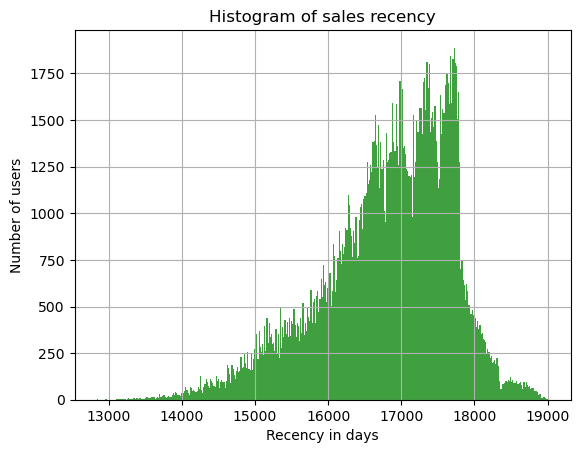

In [131]:
#Recency plot
x = rfm.Recency
mu = np.mean(rfm.Recency)
sigma = math.sqrt(np.var(rfm.Recency))
n, bins, patches = plt.hist(x, 400, facecolor='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of users')
plt.title(r'Histogram of sales recency')
plt.grid(True)

In [132]:
rfm.reset_index(inplace = True)

In [133]:
customerid = rfm.user_id.values

In [134]:
#scale all RFMT values in the range 1-5
min_max_scaler = MinMaxScaler((1,5))
scaled = min_max_scaler.fit_transform(rfm[["Recency","Frequency","Monetary","Tenure"]])

In [135]:
scaled.shape

(199583, 4)

In [136]:
rfm.columns

Index(['user_id', 'Recency', 'Frequency', 'Monetary', 'Tenure'], dtype='object')

In [137]:
scaled

array([[3.44527323, 1.03030303, 1.00009009, 2.90683562],
       [3.29674072, 1.01515152, 1.00000713, 2.37926111],
       [3.17480136, 1.        , 1.00000461, 2.83116188],
       ...,
       [4.27030971, 1.06060606, 1.00003462, 1.8295556 ],
       [4.15809956, 1.        , 1.        , 1.42548635],
       [3.61780444, 1.        , 1.00001898, 3.339461  ]])

In [138]:
rfm = pd.DataFrame(scaled, columns=rfm.columns[1:])


In [139]:
# rfm['customerid'] = customerid

In [140]:
rfm.head()

,Recency,Frequency,Monetary,Tenure
0,3.445273,1.030303,1.000090,2.906836
1,3.296741,1.015152,1.000007,2.379261
2,3.174801,1.000000,1.000005,2.831162
3,3.558132,1.015152,1.000007,2.133678
4,3.508189,1.000000,1.000182,3.553632


/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/k

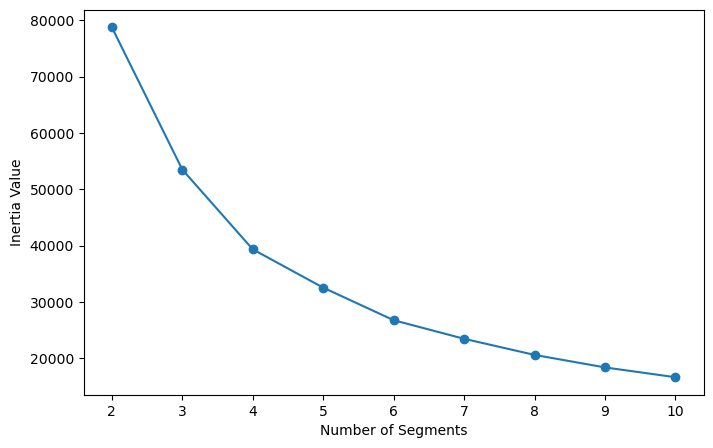

In [141]:
X = rfm.values 
n_cluster = range(2, 11, 1)
cost = []

for i in n_cluster:
    model = KMeans(n_clusters=i, random_state=13)
    model.fit(X)
    cost.append(model.inertia_)
    
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(n_cluster, cost, marker="o")
ax.set_xlabel("Number of Segments")
ax.set_ylabel("Inertia Value")
plt.show()

In [142]:
#Same as what we got before. 6 clusters are best
n_cluster = 6

model = KMeans(n_clusters=n_cluster, random_state=2023)
y = model.fit_predict(rfm[["Recency","Frequency","Monetary","Tenure"]])

rfm["Segment"] = y

/Users/kalra/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [143]:
rfm['user_id'] = customerid

In [144]:
rfm.head() 

,Recency,Frequency,Monetary,Tenure,Segment,user_id
0,3.445273,1.030303,1.000090,2.906836,4,---2PmXbF47D870stH1jqA
1,3.296741,1.015152,1.000007,2.379261,0,---UgP94gokyCDuB5zUssA
2,3.174801,1.000000,1.000005,2.831162,4,---r61b7EpVPkb4UVme5tA
3,3.558132,1.015152,1.000007,2.133678,0,--2bpE5vyR-2hAP7sZZ4lA
4,3.508189,1.000000,1.000182,3.553632,2,--3WaS23LcIXtxyFULJHTA


In [145]:
#lets take a look at each segment in terms of RFMT
rfm.groupby("Segment").mean()

,Recency,Frequency,Monetary,Tenure
Segment,,,,
0,3.543008,1.005577,1.000044,2.416182
1,2.444686,1.012082,1.000423,3.768179
2,3.785212,1.023364,1.001550,3.621151
3,4.056344,1.009015,1.000122,1.917295
4,3.115680,1.008397,1.000110,3.063021
5,4.082361,1.022337,1.000975,2.860128


0.2 weight for recency

0.2 weight for frequency

0.6 weight for monetary

This weighted score is used to form the categories for the customers

In [146]:
rfm["Score"] = 0.2*rfm['Recency'] + 0.2*rfm['Frequency'] + 0.6*rfm['Monetary']

In [147]:
#lets take a look at each segment in terms of RFMT
rfm.groupby("Segment").mean().sort_values(by = [('Score')], ascending = False)

,Recency,Frequency,Monetary,Tenure,Score
Segment,,,,,
5,4.082361,1.022337,1.000975,2.860128,1.621525
3,4.056344,1.009015,1.000122,1.917295,1.613145
2,3.785212,1.023364,1.001550,3.621151,1.562645
0,3.543008,1.005577,1.000044,2.416182,1.509743
4,3.115680,1.008397,1.000110,3.063021,1.424881
1,2.444686,1.012082,1.000423,3.768179,1.291607


In [148]:
humanization = {0: "Silver", 1: "Dirt", 2: "Gold", 3: "Diamond", 4: "Bronze", 5: "Platinum"}
rfm["Segment"].replace(humanization,inplace=True)
rfm.head()

,Recency,Frequency,Monetary,Tenure,Segment,user_id,Score
0,3.445273,1.030303,1.000090,2.906836,Bronze,---2PmXbF47D870stH1jqA,1.495169
1,3.296741,1.015152,1.000007,2.379261,Silver,---UgP94gokyCDuB5zUssA,1.462383
2,3.174801,1.000000,1.000005,2.831162,Bronze,---r61b7EpVPkb4UVme5tA,1.434963
3,3.558132,1.015152,1.000007,2.133678,Silver,--2bpE5vyR-2hAP7sZZ4lA,1.514661
4,3.508189,1.000000,1.000182,3.553632,Gold,--3WaS23LcIXtxyFULJHTA,1.501747


In [149]:
rfm

,Recency,Frequency,Monetary,Tenure,Segment,user_id,Score
0,3.445273,1.030303,1.000090,2.906836,Bronze,---2PmXbF47D870stH1jqA,1.495169
1,3.296741,1.015152,1.000007,2.379261,Silver,---UgP94gokyCDuB5zUssA,1.462383
2,3.174801,1.000000,1.000005,2.831162,Bronze,---r61b7EpVPkb4UVme5tA,1.434963
3,3.558132,1.015152,1.000007,2.133678,Silver,--2bpE5vyR-2hAP7sZZ4lA,1.514661
4,3.508189,1.000000,1.000182,3.553632,Gold,--3WaS23LcIXtxyFULJHTA,1.501747
...,...,...,...,...,...,...,...
199578,3.405059,1.000000,1.000000,2.285026,Silver,zzsoQwLw7kQcMq73JKZNAQ,1.481012
199579,4.174964,1.000000,1.000001,1.479029,Diamond,zzsqjDvanJhH9tn8NautOQ,1.634993
199580,4.270310,1.060606,1.000035,1.829556,Diamond,zztkCqqgR6VntYbqio4UTQ,1.666204
199581,4.158100,1.000000,1.000000,1.425486,Diamond,zzvLsOhm7gBMQDygMBDrHg,1.631620


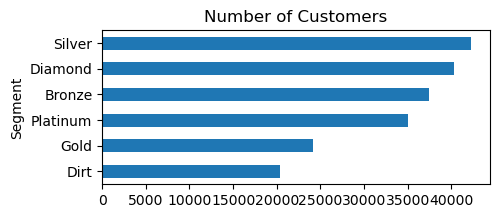

In [150]:
#group by topic and plot rows in the descending order
rfm.groupby('Segment').size().sort_values(ascending=True)\
    .plot(title="Number of Customers", kind='barh',figsize=(5,2))
plt.show()

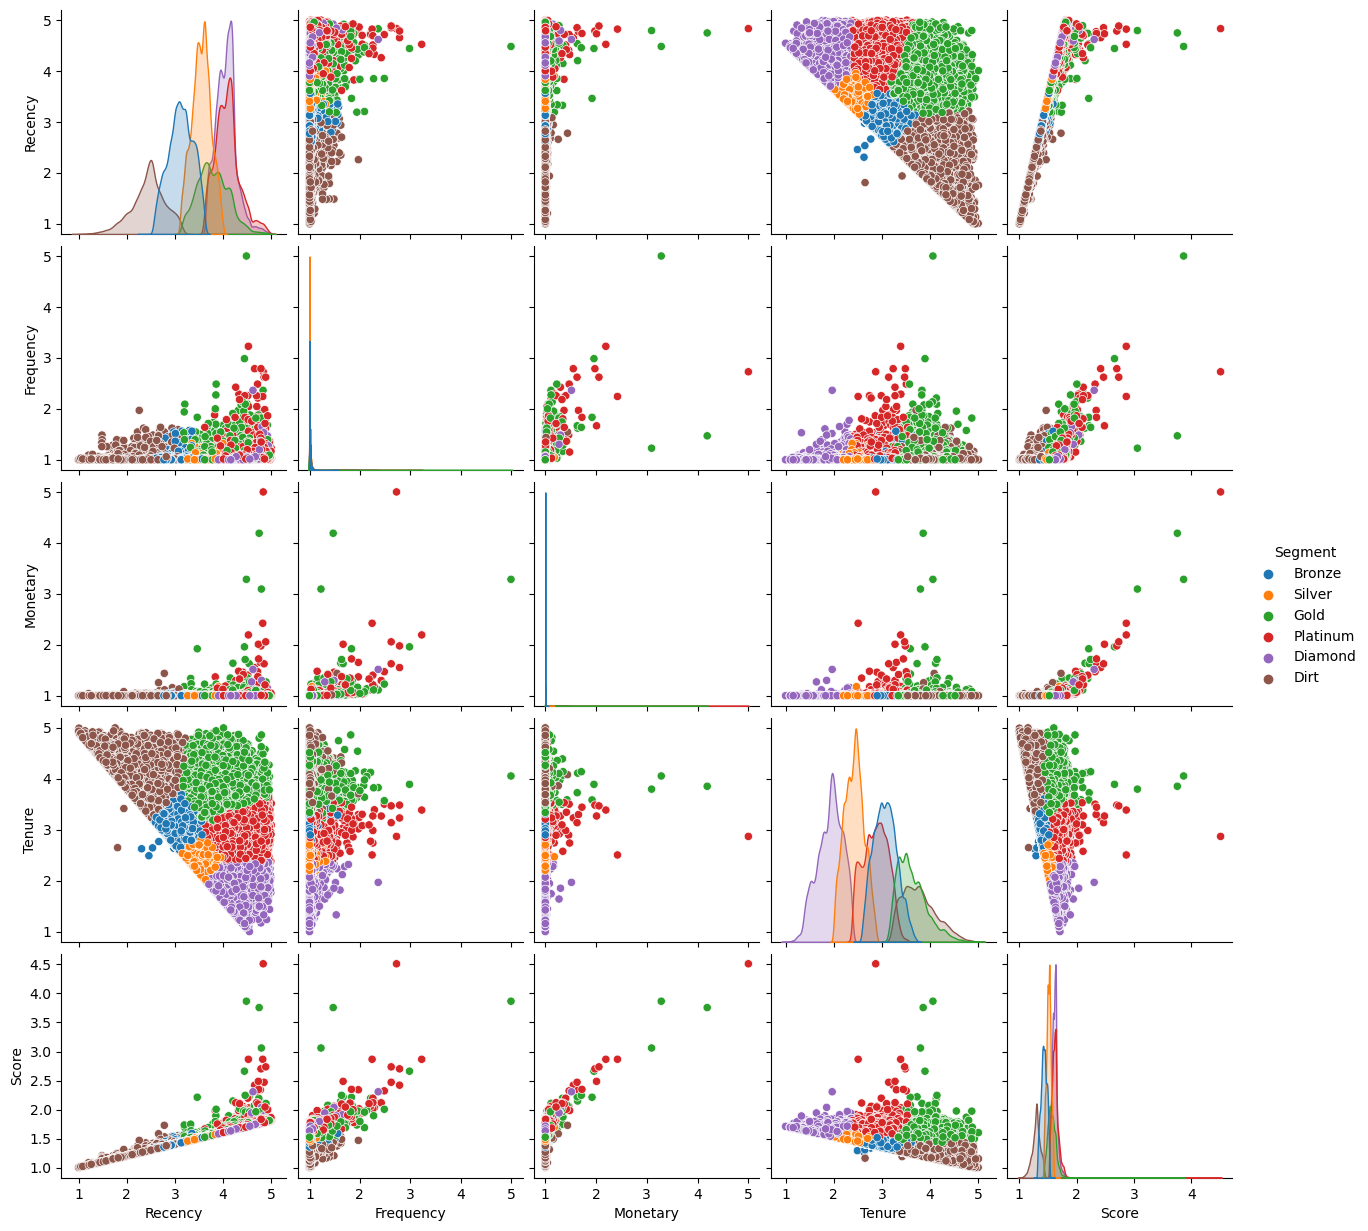

Time taken to make pairplots is 152.85 seconds


In [151]:
tic = time.time()
sns.pairplot(rfm, hue="Segment")
plt.show()
toc = time.time()
print(f"Time taken to make pairplots is {round(toc-tic, 2)} seconds")